In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline

In [2]:
import os
import sys
import pandas as pd
import numpy as np

In [3]:
from google.cloud import bigquery
client = bigquery.Client()

In [10]:
sql = """
SELECT 
    TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(created_utc),DAY) as date_submission,
    COUNT(*) as num_submissions
FROM `fh-bigquery.reddit_posts.2018_08`
GROUP BY date_submission
ORDER BY date_submission
"""
sub = client.query(sql).to_dataframe()
sub.head()

,date_submission,num_submissions
0,2018-08-01 00:00:00+00:00,466174
1,2018-08-02 00:00:00+00:00,451044
2,2018-08-03 00:00:00+00:00,446405
3,2018-08-04 00:00:00+00:00,394350
4,2018-08-05 00:00:00+00:00,390598


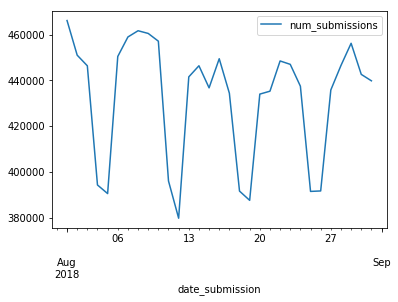

In [12]:
sub.plot(kind='line',x='date_submission',y = 'num_submissions');

The average number of post on weekends are less than the average number of posts on weekdays 

In [23]:
# Total number of submissions (Millions)
print('Total number of submissions in August, 2018: {0:.1f}M'.format(sub['num_submissions'].sum()/1E6))

Total number of submissions in August, 2018: 13.4M


### When did post go viral in the month of August

In [27]:
sql = """
SELECT
    EXTRACT(DAY FROM TIMESTAMP_SECONDS(created_utc)) AS day,
    EXTRACT(HOUR FROM TIMESTAMP_SECONDS(created_utc)) AS hour,
    SUM(IF(score >= 3000,1,0)) as high_score
FROM `fh-bigquery.reddit_posts.2018_08`
GROUP BY day, hour
ORDER BY day, hour
"""

viral_post = client.query(sql).to_dataframe()
viral_post.head()

,day,hour,high_score
0,1,0,46
1,1,1,54
2,1,2,43
3,1,3,32
4,1,4,29


In [28]:
viral_post_pivot_table = viral_post.pivot(index = 'day', columns = 'hour', values = 'high_score')

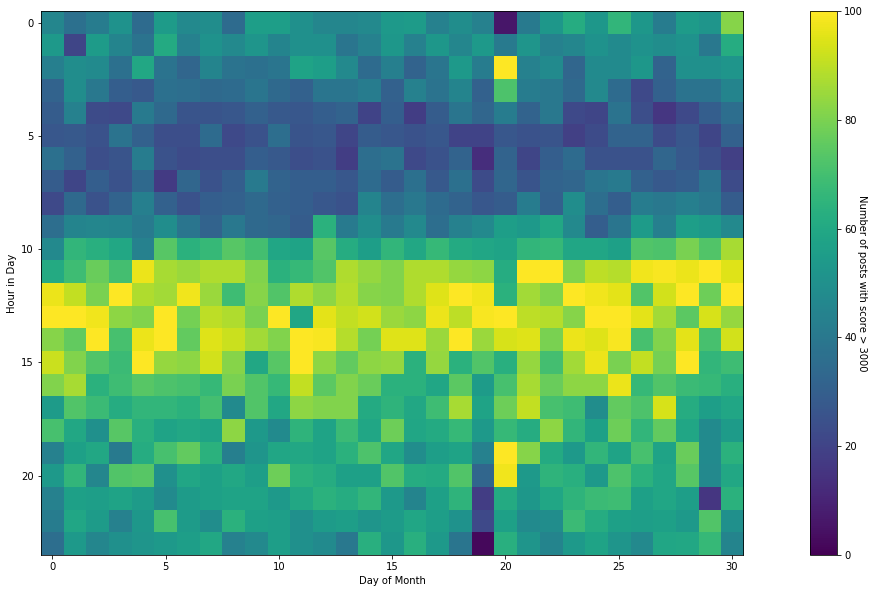

In [66]:
# The colorbar shows the number of posts which had score > 3000
import matplotlib.pyplot as plt
plt.figure(figsize=(24,10))
plt.imshow(viral_post_pivot_table.T, vmax = 100 , vmin = 0)
cb = plt.colorbar();
cb.set_label('Number of posts with score > 3000', rotation = 270)
plt.ylabel('Hour in Day')
plt.xlabel('Day of Month');

Most post go viral during the day time between 10:00 am and 3:00 pm, only Aug 20th saw more than 100 posts go viral at 2 am

In [77]:
sql = """
SELECT
    EXTRACT(DAYOFWEEK FROM TIMESTAMP_SECONDS(created_utc)) AS day_of_week,
    EXTRACT(HOUR FROM TIMESTAMP_SECONDS(created_utc)) AS hour,
    SUM(IF(score >= 3000,1,0)) as high_score
FROM `fh-bigquery.reddit_posts.2018_08`
GROUP BY day_of_week, hour
ORDER BY day_of_week, hour
"""

viral_post_dow = client.query(sql).to_dataframe()
viral_post_dow.head()

,day_of_week,hour,high_score
0,1,0,200
1,1,1,182
2,1,2,220
3,1,3,139
4,1,4,145


In [81]:
viral_post_dow['high_score'].describe()

count    168.000000
mean     251.273810
std       96.565308
min       88.000000
25%      176.000000
50%      240.000000
75%      324.500000
max      471.000000
Name: high_score, dtype: float64

In [80]:
viral_post_dow_pivot_table = df2.pivot(index = 'day_of_week', columns = 'hour', values = 'high_score')

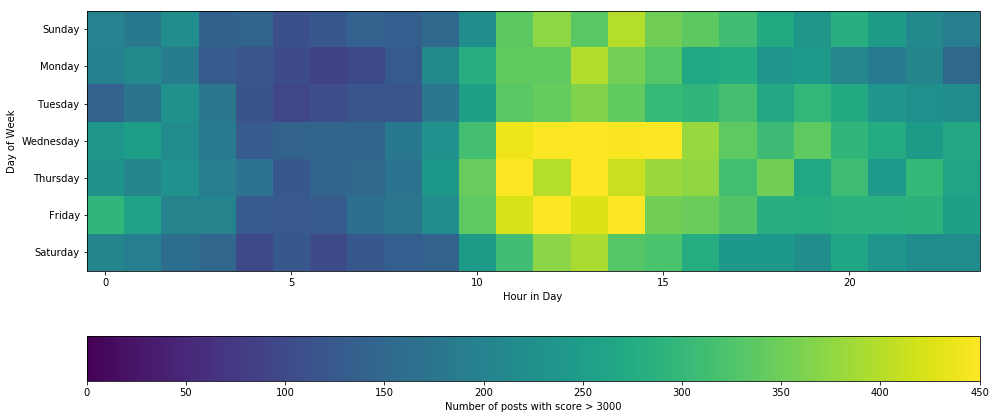

In [99]:
# The colorbar shows the number of posts which had score > 3000
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.imshow(viral_post_dow_pivot_table, vmax = 450 , vmin = 0)
cb = plt.colorbar(orientation = 'horizontal');
cb.set_label('Number of posts with score > 3000', rotation = 0)
plt.xlabel('Hour in Day')
plt.ylabel('Day of Week')

names = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
plt.yticks(range(len(names)), names, rotation = 'horizontal')
plt.savefig('temp');

### Which subreddit got the most score?

In [117]:
sql = """
SELECT 
    subreddit,
    SUM(SCORE) AS sum_score
FROM `fh-bigquery.reddit_posts.2018_08`
GROUP BY subreddit 
ORDER BY sum_score DESC
"""
subreddit_score = client.query(sql).to_dataframe()
subreddit_score.head()

,subreddit,sum_score
0,funny,29933612
1,aww,27138456
2,The_Donald,20155123
3,politics,18961579
4,pics,18734253


In [161]:
subreddit_score_top = subreddit_score.iloc[:10]

In [162]:
subreddit_score_top.index = subreddit_score_top['subreddit']

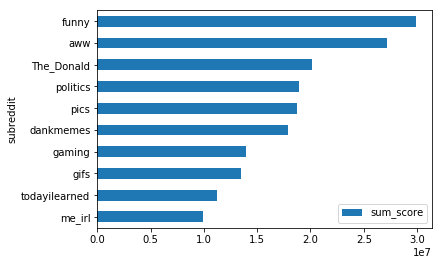

In [163]:
subreddit_score_top.plot(kind='barh').invert_yaxis()

### Which subreddit had most number of unique authors?

In [166]:
sql = """
SELECT 
    subreddit,
    TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(created_utc),DAY) as date_submission,
    COUNT(DISTINCT(author)) AS unique_authors   
FROM `fh-bigquery.reddit_posts.2018_08`
WHERE author NOT in (SELECT author FROM `fh-bigquery.reddit_comments.bots_201505`)
GROUP BY subreddit, date_submission
HAVING unique_authors > 100
ORDER BY date_submission ASC, unique_authors DESC
"""
unique_authors = client.query(sql).to_dataframe()
unique_authors.head()

,subreddit,date_submission,unique_authors
0,AskReddit,2018-08-01 00:00:00+00:00,4496
1,NoMansSkyTheGame,2018-08-01 00:00:00+00:00,2249
2,FortNiteBR,2018-08-01 00:00:00+00:00,1964
3,PewdiepieSubmissions,2018-08-01 00:00:00+00:00,1751
4,Showerthoughts,2018-08-01 00:00:00+00:00,1623


In [201]:
unique_authors_aug = unique_authors.groupby('subreddit')['unique_authors'].sum()

In [202]:
#unique_authors_aug = pd.DataFrame(unique_authors_aug)

In [203]:
unique_authors_aug_top = unique_authors_aug.sort_values(ascending = False).iloc[:10]

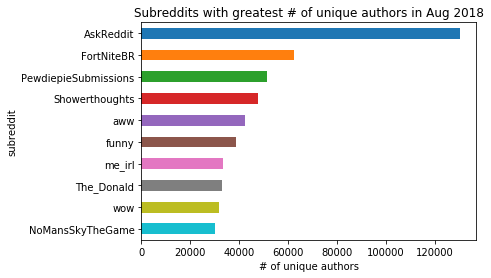

In [210]:
unique_authors_aug_top.plot(kind='barh', x = 'unique_authors').invert_yaxis()
plt.title('Subreddits with greatest # of unique authors in Aug 2018')
plt.xlabel('# of unique authors');

### Which subreddit got the most new authors compared to previous month?

In [215]:
sql = """
SELECT 
    subreddit,
    COUNT(DISTINCT(author)) AS unique_authors   
FROM `fh-bigquery.reddit_posts.2018_08`
WHERE 
    author NOT IN (SELECT DISTINCT(author) FROM `fh-bigquery.reddit_posts.2018_07`)
    AND subreddit IN (SELECT subreddit FROM `fh-bigquery.reddit_posts.2018_08` GROUP BY subreddit ORDER BY SUM(score) DESC LIMIT 50)
GROUP BY subreddit
HAVING unique_authors > 100
ORDER BY unique_authors DESC
"""
unique_new_authors_aug = client.query(sql).to_dataframe()
unique_new_authors_aug.head()


,subreddit,unique_authors
0,AskReddit,32814
1,FortNiteBR,18769
2,PewdiepieSubmissions,18617
3,aww,15903
4,funny,13899


In [222]:
unique_new_authors_aug_top = unique_new_authors_aug.iloc[:10]

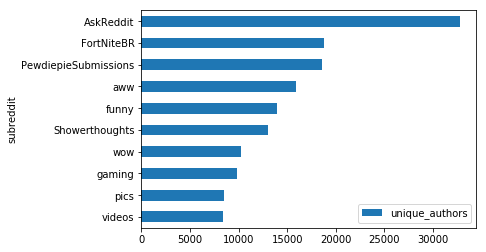

In [230]:
unique_new_authors_aug_top.set_index('subreddit').plot(kind='barh').invert_yaxis()

On average the top subreddits added 15k new authors with AskReddit adding the highest 32k and videos adding 10k (10th place) authors respectively. Most subreddits which have the most number of unique authors also added the most number of new authors, the only exception being 'gaming','pics' and 'video' 